# Section 1: Goal & Imports

**Explanation**  
We aim to predict the critical temperature (TC) of materials using machine learning. Steps:
1. Expand features using matminer (Magpie descriptors).
2. Split data into train/test and perform EDA.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = False
print('Imports OK')

Imports OK


**Questions**
- Why do we need feature expansion for material properties?

## Section 2: Load Dataset
**Explanation** 
- We load a dataset of materials with their critical temperature (TC).
- Important: Ensure the file path is correct.

In [2]:
csv_path = Path('..') / 'data' / 'DS1+DS2.csv'
assert csv_path.exists(), f"Could not find {csv_path}. Adjust the path if you moved the file."

# Load data
df = pd.read_csv(csv_path)
df.head(2)

,Name,TC,Ag,Al,Am,As,Au,B,Ba,Be,...,Ti,Tl,Tm,U,V,W,Y,Yb,Zn,Zr
0,Ag4Ce3Ge4,10.0,0.363636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Ag51Pr14,13.0,0.784615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Section 3: Train/Test Split
**Explanation**  
- We separate original numeric features and Magpie-augmented features.

In [3]:
y = df['TC']
X = df.drop(columns=['TC'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=123, shuffle=True
)
X_train.head(2)

,Name,Ag,Al,Am,As,Au,B,Ba,Be,Bi,...,Ti,Tl,Tm,U,V,W,Y,Yb,Zn,Zr
3689,Ba5Fe12O31Ti3Zn2,0.0,0.0,0.0,0.0,0.0,0.0,0.09434,0.0,0.0,...,0.056604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037736,0.0
3681,Ba3Fe5Mo5O30Sr7,0.0,0.0,0.0,0.0,0.0,0.0,0.06000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


## Section 3: Feature Expansion with Matminer
**Explanation**  
- StrToComposition converts chemical formula strings into composition objects.
- ElementProperty adds Magpie descriptors (statistics of elemental properties).
- This increases feature richness for better predictions.

In [4]:
X_train = StrToComposition().featurize_dataframe(X_train, 'Name')
ep = ElementProperty.from_preset(preset_name='magpie',impute_nan=True)
X_train = ep.featurize_dataframe(X_train, col_id='composition')
print('After Magpie expansion:', X_train.shape, y_train.shape)
X_train.head(2)

StrToComposition:   0%|          | 0/3192 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/3192 [00:00<?, ?it/s]

After Magpie expansion: (3192, 219) (3192,)


,Name,Ag,Al,Am,As,Au,B,Ba,Be,Bi,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
3689,Ba5Fe12O31Ti3Zn2,0.0,0.0,0.0,0.0,0.0,0.0,0.09434,0.0,0.0,...,2.110663,0.477887,0.739370,0.0,12.0,229.0,217.0,98.773585,101.508722,12.0
3681,Ba3Fe5Mo5O30Sr7,0.0,0.0,0.0,0.0,0.0,0.0,0.06000,0.0,0.0,...,2.110663,0.211066,0.379919,0.0,12.0,229.0,217.0,98.240000,103.488000,12.0


## Section 4: EDA on Training Data
**Explanation**  
- Use describe() to understand TC distribution.
- Histogram shows skew and range.

,TC_train
count,3192.000000
mean,340.187647
std,307.716451
min,0.000000
25%,60.000000
50%,283.500000
75%,550.000000
max,1388.000000


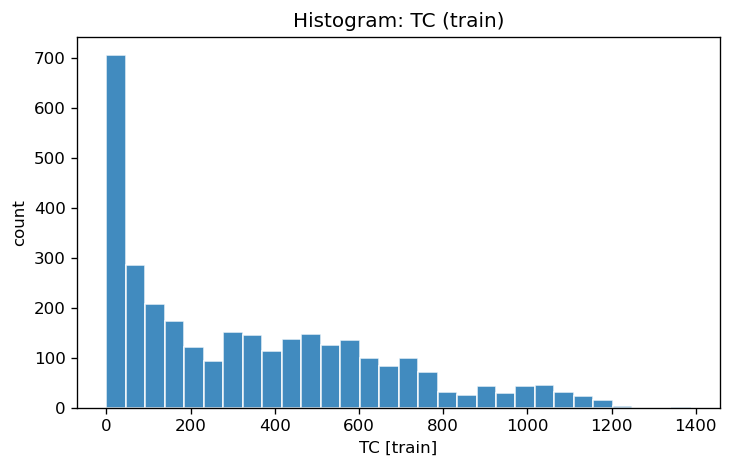

In [5]:
display(pd.DataFrame({'TC_train': y_train}).describe())
plt.figure(figsize=(6.2, 4.0))
plt.hist(y_train, bins=30, color='tab:blue', alpha=0.85, edgecolor='white')
plt.xlabel('TC [train]'); plt.ylabel('count')
plt.title('Histogram: TC (train)')
plt.tight_layout(); plt.show()

## Section 5: Predictor
**Explanation**  
- Drop name
- Create predictor
- check with cross val score on training set

In [6]:
X_train = X_train.select_dtypes(include=[np.number])
X_train.head(2)

,Ag,Al,Am,As,Au,B,Ba,Be,Bi,Bk,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
3689,0.0,0.0,0.0,0.0,0.0,0.0,0.09434,0.0,0.0,0.0,...,2.110663,0.477887,0.739370,0.0,12.0,229.0,217.0,98.773585,101.508722,12.0
3681,0.0,0.0,0.0,0.0,0.0,0.0,0.06000,0.0,0.0,0.0,...,2.110663,0.211066,0.379919,0.0,12.0,229.0,217.0,98.240000,103.488000,12.0


In [7]:
rf = RandomForestRegressor(random_state=123)
cv = KFold(n_splits=5, shuffle=True, random_state=123)
scores = cross_val_score(rf, X_train, y_train, scoring='r2', cv=cv)
print('R^2 folds    :', np.round(scores, 4))
print('Mean±Std R^2 : {:.4f} ± {:.4f}'.format(scores.mean(), scores.std()))

R^2 folds    : [0.8635 0.8907 0.8865 0.8682 0.8612]
Mean±Std R^2 : 0.8740 ± 0.0122


## Section 6: Train and Test
**Explanation**  
- Train on all training data-
- augment test data with magpie features
- Test on test data

#### Train random forsest model

In [9]:
rf.fit(X_train,y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### augment test data with magpie features

In [10]:
X_test = StrToComposition().featurize_dataframe(X_test, 'Name')
ep = ElementProperty.from_preset(preset_name='magpie',impute_nan=True)
X_test = ep.featurize_dataframe(X_test, col_id='composition')
print('After Magpie expansion:', X_test.shape, y_test.shape)
X_test.head(2)

StrToComposition:   0%|          | 0/1368 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/1368 [00:00<?, ?it/s]

After Magpie expansion: (1368, 219) (1368,)


,Name,Ag,Al,Am,As,Au,B,Ba,Be,Bi,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
1544,Co2Fe0.5GaMn0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.110663,1.038107,0.778503,1.548471,64.0,229.0,165.0,168.750000,52.375000,194.0
4186,Co2Fe8Si2Sm1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.110663,1.537096,0.709429,2.110663,166.0,229.0,63.0,218.461538,15.597633,229.0


#### Remove non-numerical values

In [11]:
X_test = X_test.select_dtypes(include=[np.number])
X_test.head(2)

,Ag,Al,Am,As,Au,B,Ba,Be,Bi,Bk,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
1544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.110663,1.038107,0.778503,1.548471,64.0,229.0,165.0,168.750000,52.375000,194.0
4186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.110663,1.537096,0.709429,2.110663,166.0,229.0,63.0,218.461538,15.597633,229.0


#### predict

In [13]:
y_test_predict = rf.predict(X_test)
score = r2_score(y_test,y_test_predict)
print('R^2    :', np.round(score, 4))

R^2    : 0.8873


## Section 7: Predict for unknown materials
**to do**  
- start with the etnire dataset
- augment the entire data with magpie features
- Train random forest regressor
- Load you new compounds
- add columns for fractional compositions
- augment data of new compounds with magpie features
- predict with trained random forest model